
# Figures

In [ ]:
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')

import sys
code_path = "/content/drive/My Drive/Master Thesis/Data"
if code_path not in sys.path:
    sys.path.append(code_path)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import re

Mounted at /content/drive


In [ ]:
# Pick dataset and model
dataset_choice = "Lapt14"
model_choice = "mistral"

In [ ]:
####### Preparation Summary Statistics Table 1 and 8 #######

data_path = f"/content/drive/My Drive/Master Thesis/Data/{model_choice}/Filtered_{dataset_choice}_{model_choice}.csv" # adjust to needed dataset
df = pd.read_csv(data_path)

df_count = df[df['generated_sentence'].notna()]
df_count = df_count[df_count['generated_sentence'].str.strip().ne('')]
df_count = df_count[df_count['generated_sentence'].str.strip().str.lower().ne('none')]

polarity_counts = df_count['sentiment'].value_counts()
polarity_freq = df_count['sentiment'].value_counts(normalize=True).round(3) * 100

df_polarity_stats = pd.DataFrame({
    'Sentiment Polarity': polarity_counts.index,
    'Count': polarity_counts.values,
    'Frequency (%)': polarity_freq.values
})

total_row = pd.DataFrame({
    'Sentiment Polarity': ['Total'],
    'Count': [df_polarity_stats['Count'].sum()],
    'Frequency (%)': [df_polarity_stats['Frequency (%)'].sum()]
})

df_polarity_stats = pd.concat([df_polarity_stats, total_row], ignore_index=True)

desired_order = ['positive', 'negative', 'neutral', 'Total']
df_polarity_stats = df_polarity_stats.set_index('Sentiment Polarity').loc[desired_order].reset_index()

display(df_count)
display(df_polarity_stats)

,generated_sentence,original_aspect,used_extended_aspect,sentiment
0,It's lightning fast to get started with this m...,boot time,boot time,positive
1,The Acer Chromebook Spin 15 has an impressive ...,boot time,boot time,positive
2,The HP EliteBook x360 1040 G9 boots up quickly...,boot time,boot time,positive
3,The MacBook Pro's rapid start up times allow f...,boot time,boot time,positive
4,This model has an impressive quick start up sp...,boot time,boot time,positive
...,...,...,...,...
3371,You will need an external DVD player since the...,disc drive,disc drive,negative
3372,Resizing images without losing quality was eas...,res,res,positive
3373,High Resolution Screen Provides Great Clarity ...,res,resolution,positive
3374,This thing's so damn heavy it feels like dragg...,res,res,negative


,Sentiment Polarity,Count,Frequency (%)
0,positive,1895,56.1
1,negative,707,20.9
2,neutral,774,22.9
3,Total,3376,99.9


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

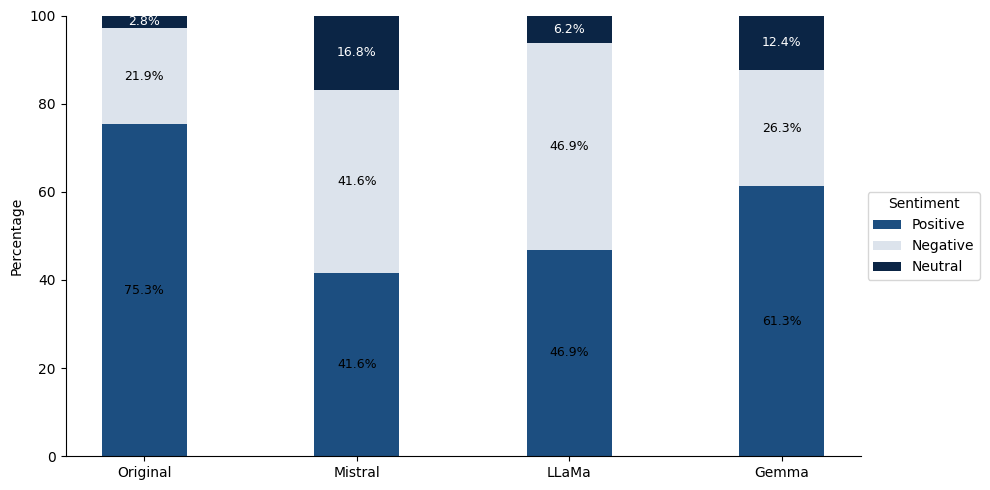

In [ ]:
####### Preparation Figure 12 #######

colors = {
    "Positive": "#1c4e80",
    "Negative": "#dce3ec",
    "Neutral": "#0b2545"
}

# Rest 15 Example from Table 8 (Appendix C)
labels = ['Original', 'Mistral', 'LLaMa', 'Gemma']
positive = [75.3, 41.6, 46.9, 61.3]
negative = [21.9, 41.6, 46.9, 26.3]
neutral = [2.8, 16.8, 6.2, 12.4]

x = range(len(labels))
bar_width = 0.4

fig, ax = plt.subplots(figsize=(10, 5))

p1 = ax.bar(x, positive, width=bar_width, label='Positive', color=colors["Positive"])
p2 = ax.bar(x, negative, width=bar_width, bottom=positive, label='Negative', color=colors["Negative"])
bottom_neutral = [positive[i] + negative[i] for i in range(len(positive))]
p3 = ax.bar(x, neutral, width=bar_width, bottom=bottom_neutral, label='Neutral', color=colors["Neutral"])

for bars, values, color_key in zip([p1, p2, p3], [positive, negative, neutral], ['Positive', 'Negative', 'Neutral']):
    for i, (bar, val) in enumerate(zip(bars, values)):
        height = bar.get_height()
        y = bar.get_y() + height / 2
        color = 'white' if colors[color_key] == "#0b2545" else 'black'
        ax.text(bar.get_x() + bar.get_width()/2, y, f"{val:.1f}%", ha='center', va='center', fontsize=9, color=color)

ax.set_ylabel('Percentage')
ax.set_ylim(0, 100)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.tick_params(axis='x', rotation=0)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Sentiment')
ax.set_axisbelow(True)
ax.yaxis.grid(False)

plt.tight_layout()
plt.savefig("SD_Rest15.pdf", format="pdf", dpi=300, bbox_inches="tight")
files.download("SD_Rest15.pdf")

plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

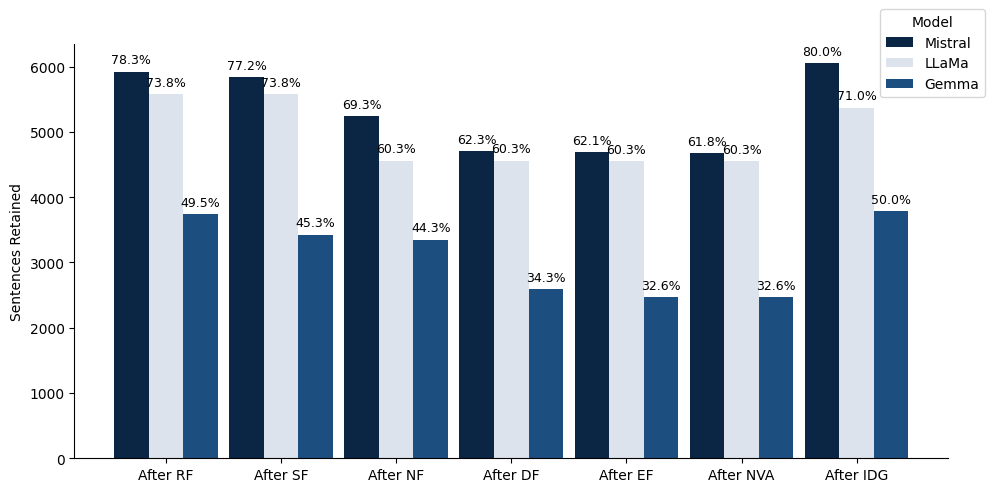

In [ ]:
####### Preparation Figure 13 #######

colors = {
    "Mistral": "#0b2545",
    "LLaMa": "#dce3ec",
    "Gemma": "#1c4e80"
}

# Rest 15 Example from Table 10 (Appendix C)
rejections_dict_rest15 = {
    "MF": {"Mistral": 1639, "LLaMa": 1978, "Gemma": 3818},
    "SF": {"Mistral": 85, "LLaMa": 5, "Gemma": 316},
    "NF": {"Mistral": 600, "LLaMa": 1017, "Gemma": 76},
    "DF": {"Mistral": 526, "LLaMa": 1, "Gemma": 756},
    "EF": {"Mistral": 15, "LLaMa": 4, "Gemma": 126},
    "NVA": {"Mistral": 23, "LLaMa": 0, "Gemma": 0}
}
initial_generated = 7560

final_counts = {"Mistral": 6050, "LLaMa": 5371, "Gemma": 3782}

stages = ["After RF", "After SF", "After NF", "After DF", "After EF", "After NVA", "After IDG"]
models = ["Mistral", "LLaMa", "Gemma"]
x = np.arange(len(stages))
width = 0.3

retention_data = []
for model in models:
    current = initial_generated
    retained = []
    percents = []
    for stage in ["MF", "SF", "NF", "DF", "EF", "NVA"]:
        current -= rejections_dict_rest15[stage][model]
        retained.append(current)
        percents.append(f"{round(current / initial_generated * 100, 1)}%")
    retained.append(final_counts[model])
    percents.append(f"{round(final_counts[model] / initial_generated * 100, 1)}%")
    retention_data.append((retained, percents))

fig, ax = plt.subplots(figsize=(10, 5))

for i, model in enumerate(models):
    offset = (i - 1) * width
    retained, percents = retention_data[i]
    bars = ax.bar(x + offset, retained, width, label=model, color=colors[model], edgecolor='none')
    for bar, pct in zip(bars, percents):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height + 80, pct, ha='center', va='bottom', fontsize=9)

ax.set_ylabel("Sentences Retained")
ax.set_xticks(x)
ax.set_xticklabels(stages, ha="center")
ax.legend(title="Model", loc="upper right", bbox_to_anchor=(1.05, 1.1))
ax.grid(False)

for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)

plt.tight_layout()
plt.savefig("RR_Rest15.pdf", format="pdf", dpi=300, bbox_inches="tight")
files.download("RR_Rest15.pdf")

plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

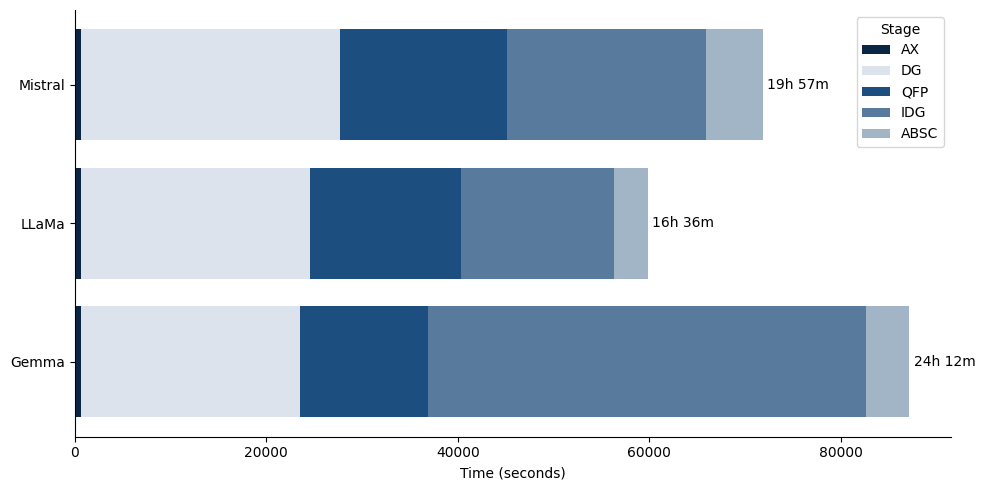

In [ ]:
####### Preparation Figure 14 #######

stage_colors = {
    "AX": "#0b2545",
    "DG": "#dce3ec",
    "QFP": "#1c4e80",
    "IDG": "#587b9d",
    "ABSC": "#a2b5c7"
}

# Average inference time across the four datasets from Table 11 (Appendix D)
data = {
    "Model": ["Mistral", "LLaMa", "Gemma"],
    "AX": [657.34, 686.12, 637.60],
    "DG": [27006.95, 23914.73, 22922.96],
    "QFP": [17446.76, 15747.26, 13388.17],
    "IDG": [20855.61, 15965.62, 45634.88],
    "ABSC": [5874.34, 3503.96, 4551.40]
}

df = pd.DataFrame(data)

df["Total"] = df[["AX", "DG", "QFP", "IDG", "ABSC"]].sum(axis=1)
df["Total_hm"] = df["Total"].apply(lambda x: f"{int(x // 3600)}h {int((x % 3600) // 60)}m")

fig, ax = plt.subplots(figsize=(10, 5))
bottoms = [0] * len(df)

models = df["Model"].tolist()[::-1]
df = df.iloc[::-1]

for stage in stage_colors:
    ax.barh(df["Model"], df[stage], left=bottoms, color=stage_colors[stage], label=stage)
    bottoms = [i + j for i, j in zip(bottoms, df[stage])]

for i, total in enumerate(df["Total"]):
    label = df.iloc[i]["Total_hm"]
    ax.text(total + 500, i, label, va='center', fontsize=10)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.set_yticks(range(len(models)))
ax.set_yticklabels(models)
ax.set_xlabel("Time (seconds)")
ax.set_ylabel("")

ax.legend(loc='upper right', title="Stage")

plt.tight_layout()
plt.savefig("IT_Average.pdf", format="pdf", dpi=300, bbox_inches="tight")
files.download("IT_Average.pdf")

plt.show()